<a href="https://colab.research.google.com/github/Csfifty23/me50/blob/main/Q_Sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This script demonstrates multi-horizon time series forecasting using Long Short-Term Memory (LSTM) neural networks.
The model takes sequences of historical data (features A, B, and C) as input and predicts multi-step future values for each feature.

The code performs the following tasks:
1. Data Loading: Load historical time series data from a CSV file.
2. Data Preprocessing: Normalize the data using Min-Max scaling and create input-output sequences.
3. Model Architecture: Build an LSTM-based neural network model for multi-horizon forecasting.
4. Model Training: Train the model using the training dataset and validate it using a validation dataset.
5. Model Evaluation: Evaluate the trained model's performance on a separate test dataset.
6. Prediction: Generate multi-step predictions for unseen data.

Dependencies:
- numpy: For numerical operations and array manipulation.
- pandas: For data manipulation and analysis.
- sklearn.preprocessing.MinMaxScaler: For Min-Max scaling of the data.
- tensorflow.keras.models.Model: For defining and training the neural network model.
- tensorflow.keras.layers.Input, LSTM, Dense: For constructing the layers of the neural network.

Usage:
- Ensure that the 'Dataset.csv' file contains the historical time series data in columns named 'TIMESTAMP', 'A', 'B', and 'C'.
- Update the file path if the data file is located elsewhere**.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import pandas as pd
data=pd.read_csv("/content/Dataset.csv")
data.head()



,TIMESTAMP,A,B,C
0,2022032101,0,208,0
1,2022032103,0,225,0
2,2022032104,0,223,0
3,2022032104,0,221,0
4,2022032105,0,221,0


In [ ]:
data['TIMESTAMP']

0        2022032101
1        2022032103
2        2022032104
3        2022032104
4        2022032105
            ...    
28730    2022103117
28731    2022103117
28732    2022103117
28733    2022103117
28734    2022103117
Name: TIMESTAMP, Length: 28735, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import LSTM, RepeatVector

# Load your data
# Assuming you have a DataFrame named 'data' with columns TIMESTAMP, A, B, C
# Replace 'your_data.csv' with your actual data file path if loading from a file
data = pd.read_csv('/content/Dataset.csv')

In [ ]:
# Data Preprocessing
scalers = {}
for col in ['A', 'B', 'C']:
    scaler = MinMaxScaler(feature_range=(0, 1))
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    scalers[col] = scaler

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length:i + seq_length + 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
seq_length = 10
X, y = create_sequences(data[['A', 'B', 'C']].values, seq_length)

# Reshape X to 3D tensor (samples, time steps, features)
X = X.reshape(X.shape[0], seq_length, 3)

# Build the LSTM model
input_shape = (seq_length, 3)
lstm_units = 50
output_shape = 1

input_layer = Input(shape=input_shape)

In [ ]:

# Encoder LSTM with return_state=True
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(input_layer)
encoder_states = [state_h, state_c]

# Repeat the state vector to use as initial state for each time step in the decoder
decoder_input = RepeatVector(seq_length)(encoder_states[0])

# Decoder LSTM with initial_state
decoder_lstm = LSTM(lstm_units, return_sequences=True)(decoder_input, initial_state=encoder_states)

output_layer = Dense(3)(decoder_lstm)  # Assuming you want to predict A, B, and C

model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:

# Train the model
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

In [ ]:
history=model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
315/315 [==============================] - 7s 13ms/step - loss: 0.0097 - val_loss: 0.0054
Epoch 2/50
315/315 [==============================] - 4s 12ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 3/50
315/315 [==============================] - 4s 13ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 4/50
315/315 [==============================] - 3s 11ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 5/50
315/315 [==============================] - 4s 13ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 6/50
315/315 [==============================] - 3s 11ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 7/50
315/315 [==============================] - 3s 10ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 8/50
315/315 [==============================] - 4s 12ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/50
315/315 [==============================] - 4s 11ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 10/50
315/315 [==============================] - 3s 11ms/step - loss: 0.0036 - val_lo

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

# Make predictions
predicted_values = model.predict(X_test)

# Inverse transform the predictions
for i, col in enumerate(['A', 'B', 'C']):
    scaler = scalers[col]
    predicted_values[:, :, i] = scaler.inverse_transform(predicted_values[:, :, i])
    y_test[:, :, i] = scaler.inverse_transform(y_test[:, :, i])

# Now 'predicted_values' contains the forecasted values
# 'y_test' contains the actual values for comparison


135/135 [==============================] - 1s 4ms/step - loss: 0.0039
Test Loss: 0.0038757161237299442
135/135 [==============================] - 1s 3ms/step


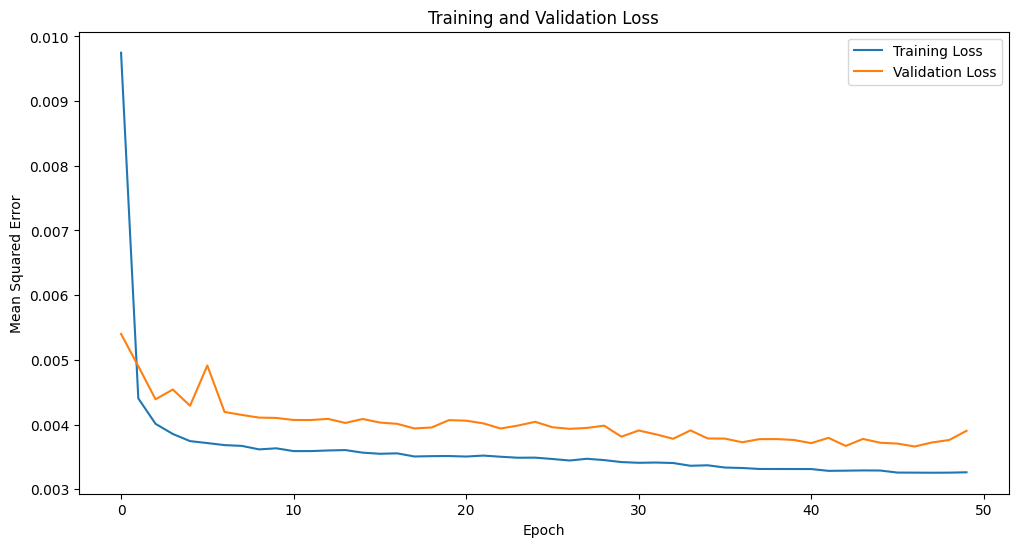

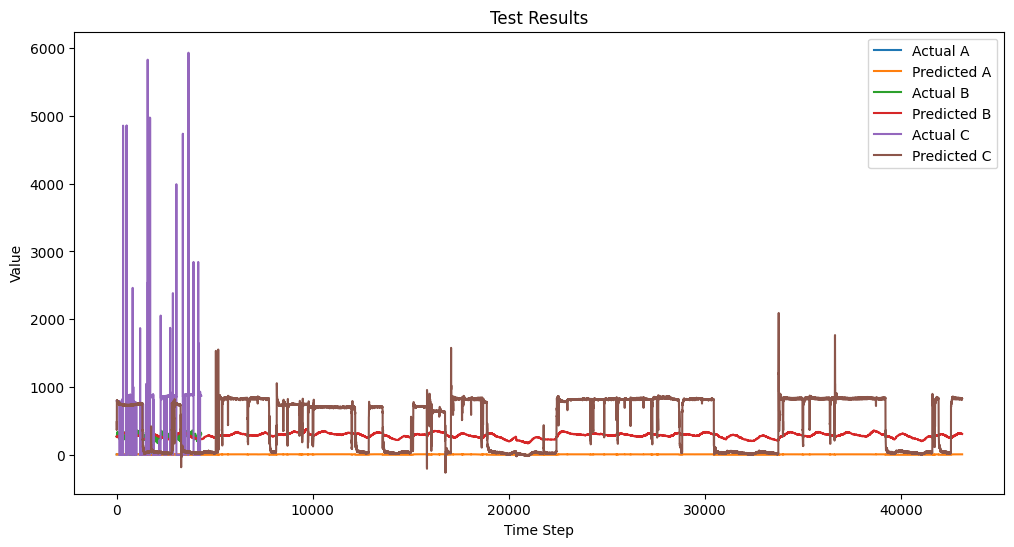

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot test results
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, :, 0].flatten(), label='Actual A')
plt.plot(predicted_values[:, :, 0].flatten(), label='Predicted A')
plt.plot(y_test[:, :, 1].flatten(), label='Actual B')
plt.plot(predicted_values[:, :, 1].flatten(), label='Predicted B')
plt.plot(y_test[:, :, 2].flatten(), label='Actual C')
plt.plot(predicted_values[:, :, 2].flatten(), label='Predicted C')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Results')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load your data
# Assuming you have a DataFrame named 'data' with columns TIMESTAMP, A, B, C

# Data Preprocessing
# Assuming 'data' is the DataFrame containing your time series data
scalers = {}
for col in ['A', 'B', 'C']:
    scaler = MinMaxScaler(feature_range=(0, 1))
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    scalers[col] = scaler

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length:i + seq_length + 1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 10  # You can adjust this window size according to your needs
X, y = create_sequences(data[['A', 'B', 'C']].values, seq_length)

# Build the LSTM model
input_shape = (seq_length, 3)  # 3 features: A, B, C
lstm_units = 50
output_shape = 1  # Predicting one value at a time

input_layer = Input(shape=input_shape)
lstm_encoder = LSTM(lstm_units)(input_layer)

# State vector
state_vector = Dense(lstm_units)(lstm_encoder)

# Decoder
decoded = LSTM(lstm_units, return_sequences=True)(state_vector)
output_layer = Dense(output_shape)(decoded)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

# Make predictions
predicted_values = model.predict(X_test)

# Inverse transform the predictions
for i, col in enumerate(['A', 'B', 'C']):
    scaler = scalers[col]
    predicted_values[:, :, i] = scaler.inverse_transform(predicted_values[:, :, i])
    y_test[:, :, i] = scaler.inverse_transform(y_test[:, :, i])

# Now 'predicted_values' contains the forecasted values
# 'y_test' contains the actual values for comparison


ValueError: ignored

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Assuming your data is stored in a DataFrame named 'df' with TIMESTAMP, A, B, and C columns
# Convert TIMESTAMP to datetime if it's not already in datetime format
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d%H')

# Set TIMESTAMP as the index of the DataFrame
df.set_index('TIMESTAMP', inplace=True)

# Prepare data for training, validation, and testing
# Assuming you want to forecast column 'A'. You can change this to 'B' or 'C' based on your requirements.
input_data = df[['A', 'B', 'C']].values

# Define the number of features (A, B, C) and the number of timesteps
num_features = input_data.shape[1]  # Number of features (A, B, C)
num_timesteps = input_data.shape[0]  # Number of timestamps

# Reshape input data into sequences of a specific length (num_timesteps)
input_sequences = []

# Choose an appropriate sequence length (num_timesteps_in_sequence) based on your requirement
num_timesteps_in_sequence = 10  # Example sequence length

for i in range(num_timesteps - num_timesteps_in_sequence):
    input_sequences.append(input_data[i:i + num_timesteps_in_sequence])

input_sequences = np.array(input_sequences)

# Prepare encoder input data, decoder input data, and decoder target data
encoder_input_data = input_sequences  # Encoder input is the same as input_sequences
decoder_input_data = input_sequences[:, 1:, :]  # Shifted by 1 timestep for teacher forcing
decoder_target_data = input_sequences[:, :-1, :]  # Predict one timestep ahead (teacher forcing)

# Define model parameters
latent_dim = 64  # Number of LSTM units in the encoder and decoder
num_epochs = 50  # Number of training epochs
batch_size = 32  # Batch size for training

# Define the encoder architecture
encoder_input = Input(shape=(num_timesteps_in_sequence, num_features))
encoder_lstm = LSTM(units=latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_input)
encoder_states = [state_h, state_c]

# Define the decoder architecture
decoder_input = Input(shape=(num_timesteps_in_sequence - 1, num_features))
decoder_lstm = LSTM(units=latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)
decoder_dense = Dense(num_features)  # Output layer for each feature (A, B, C)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn encoder_input_data & decoder_input_data into decoder_target_data
model = Model([encoder_input, decoder_input], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

# Now, you can use this trained model for making predictions and further analysis.


Epoch 1/50
719/719 [==============================] - 10s 9ms/step - loss: 146209.7031 - val_loss: 179241.0938
Epoch 2/50
719/719 [==============================] - 7s 9ms/step - loss: 130489.3750 - val_loss: 161791.0156
Epoch 3/50
719/719 [==============================] - 6s 8ms/step - loss: 117397.3125 - val_loss: 147477.6719
Epoch 4/50
719/719 [==============================] - 6s 9ms/step - loss: 106503.9453 - val_loss: 135307.0000
Epoch 5/50
719/719 [==============================] - 6s 8ms/step - loss: 97399.1250 - val_loss: 124338.9922
Epoch 6/50
719/719 [==============================] - 7s 9ms/step - loss: 88606.8047 - val_loss: 113680.5234
Epoch 7/50
719/719 [==============================] - 6s 8ms/step - loss: 80468.4453 - val_loss: 103973.5547
Epoch 8/50
719/719 [==============================] - 6s 9ms/step - loss: 72903.1328 - val_loss: 94605.3203
Epoch 9/50
719/719 [==============================] - 6s 9ms/step - loss: 65239.5625 - val_loss: 85392.0625
Epoch 10/50
719/

In [ ]:
df=pd.read_csv("/content/Dataset.csv")
df.head()

In [ ]:
df=pd.read_csv("/content/Dataset.csv")
df.head()

,TIMESTAMP,A,B,C
0,2022032101,0,208,0
1,2022032103,0,225,0
2,2022032104,0,223,0
3,2022032104,0,221,0
4,2022032105,0,221,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Load your time series data into a pandas DataFrame
# Assuming the DataFrame is named 'df'

# Convert Timestamp column to datetime type
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# Sort the DataFrame by Timestamp if it's not already sorted
df = df.sort_values(by='TIMESTAMP')

# Define the number of time steps in the input sequence
input_window_size = 10  # You can adjust this based on your requirement

# Create input sequences and corresponding target sequences
input_sequences = []
target_sequences = []

for i in range(len(df) - input_window_size):
    input_seq = df[['A', 'B', 'C']][i:i+input_window_size].values
    target_seq = df[['A', 'B', 'C']][i+input_window_size:i+input_window_size+1].values
    input_sequences.append(input_seq)
    target_sequences.append(target_seq)

# Convert input_sequences and target_sequences to numpy arrays
input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)

# Divide the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(input_sequences, target_sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [ ]:
# Define model parameters
input_features = X_train.shape[2]  # Number of input features (3 in this case)
output_features = y_train.shape[2]  # Number of output features (also 3 in this case)
encoder_units = 64
decoder_units = 64
num_epochs = 50
batch_size = 64

# Define the encoder architecture
encoder_input = Input(shape=(None, input_features))
encoder_lstm, state_h, state_c = LSTM(encoder_units, return_state=True)(encoder_input)
encoder_states = [state_h, state_c]

# Define the decoder architecture with initial state set to encoder_states
decoder_input = Input(shape=(None, output_features))
decoder_lstm = LSTM(decoder_units, return_sequences=True, return_state=True)
decoder_lstm_outputs, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)
decoder_output = Dense(output_features)(decoder_lstm_outputs)

# Create the model
model = Model([encoder_input, decoder_input], decoder_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=num_epochs, batch_size=batch_size)

# Evaluate the model on the test data
loss = model.evaluate([X_test, y_test], y_test)
print(f'Test Loss: {loss}')

# Use the trained model for predictions
def forecast(input_sequence, prediction_horizon):
    initial_state = model.layers[1].get_initial_state(inputs=np.array([input_sequence]))
    encoder_states = model.layers[1](inputs=np.array([input_sequence]), initial_state=initial_state)

    decoder_input = np.zeros((1, 1, output_features))  # Initialize with zeros for single-step prediction
    forecasts = []

    for _ in range(prediction_horizon):
        decoder_output, _, _ = model.layers[2](inputs=decoder_input, initial_state=encoder_states)
        forecast_step = model.layers[3](decoder_output)
        forecasts.append(forecast_step)
        decoder_input = np.expand_dims(np.array([forecast_step]), axis=1)

    return np.concatenate(forecasts, axis=1)


In [ ]:
import pandas as pd
data=pd.read_csv("/content/Dataset.csv")
data.head()

FileNotFoundError: ignored

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Create a DataFrame
df = pd.DataFrame(data)

# Convert 'TIMESTAMP' column to datetime and keep only the date part (year-month-day)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d%H')
df['TIMESTAMP'] = df['TIMESTAMP'].dt.date

# Sort the DataFrame by Timestamp if it's not already sorted
df = df.sort_values(by='TIMESTAMP')
data=df
# # Extract numerical features (A, B, C) and scale them (using MinMaxScaler)
# numerical_features = ['A', 'B', 'C']
# scaler = MinMaxScaler()
# df[numerical_features] = scaler.fit_transform(df[numerical_features])

# # Define the number of time steps in the input sequence
# input_window_size = 3  # For example, using the last 3 days' data to predict the next one

# # Create input sequences and corresponding target sequences
# input_sequences = []
# target_sequences = []

# for i in range(len(df) - input_window_size):
#     input_seq = df[numerical_features][i:i + input_window_size].values
#     target_seq = df[numerical_features][i + input_window_size:i + input_window_size + 1].values
#     input_sequences.append(input_seq)
#     target_sequences.append(target_seq)

# # Convert input_sequences and target_sequences to numpy arrays
# input_sequences = np.array(input_sequences)
# target_sequences = np.array(target_sequences)

# # Print shapes to verify
# print("Input Sequences Shape:", input_sequences.shape)
# print("Target Sequences Shape:", target_sequences.shape)


In [ ]:
# Sample data (replace this with your own data)
# data = pd.DataFrame({
#     'TIMESTAMP': [2022032101, 2022032103, 2022032104, 2022032104, 2022032105],
#     'A': [0, 0, 0, 0, 0],
#     'B': [208, 225, 223, 221, 221],
#     'C': [0, 0, 0, 0, 0]
# })

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data[['A', 'B', 'C']] = scaler.fit_transform(data[['A', 'B', 'C']])

# Function to create sequences with multiple columns
def create_sequences(data, input_window_size):
    sequences, targets = [], []
    for i in range(len(data) - input_window_size):
        sequence = data[['A', 'B', 'C']][i:i+input_window_size].values
        target = data['B'][i+input_window_size:i+input_window_size+1].values
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define input window size
input_window_size = 3

# Create sequences and targets
input_sequences, targets = create_sequences(data, input_window_size)

# Split data into training, validation, and test sets (similar to the previous example)
# Convert NumPy arrays to PyTorch tensors
train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()
val_inputs = torch.from_numpy(val_inputs).float()
val_targets = torch.from_numpy(val_targets).float()
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets).float()


NameError: ignored

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate

# Assuming your data is stored in a variable named 'data' with columns 'TIMESTAMP', 'A', 'B', 'C'
# Assuming 'data' is a pandas DataFrame

# Preprocessing
# data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y%m%d%H')  # Convert TIMESTAMP to datetime
# print(data["TIMESTAMP"])


In [ ]:
data.set_index('TIMESTAMP', inplace=True) # Set TIMESTAMP as index


In [ ]:
data

,A,B,C
TIMESTAMP,,,
2022-03-21,0,208,0
2022-03-21,0,208,0
2022-03-21,0,204,0
2022-03-21,0,204,0
2022-03-21,0,204,0
...,...,...,...
2022-10-31,0,270,0
2022-10-31,0,268,0
2022-10-31,0,272,0


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)  # Scale the data using Min-Max scaler
print(scaled_data)
# Prepare input features and target variable
sequence_length = 10  # You can adjust this window size as needed
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length])

X, y = np.array(X), np.array(y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

[[0.         0.13740458 0.        ]
 [0.         0.13740458 0.        ]
 [0.         0.1221374  0.        ]
 ...
 [0.         0.38167939 0.        ]
 [0.         0.33206107 0.        ]
 [0.77777778 0.53435115 0.14683075]]


In [ ]:
print("Input Sequences Shape:", X.shape)
print("Target Sequences Shape:", y.shape)
print("X_train, Shape:", X_train.shape)
print("X_temp, Shape:", X_temp.shape)
# print("Input Sequences Shape:", X.shape)
# print("Target Sequences Shape:", y.shape)

Input Sequences Shape: (28725, 10, 3)
Target Sequences Shape: (28725, 3)
X_train, Shape: (20107, 10, 3)
X_temp, Shape: (8618, 10, 3)


In [ ]:


# Encoder
encoder_inputs = Input(shape=input_shape)
encoder_lstm1 = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
encoder_lstm2 = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_lstm3 = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs2)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, 1))  # Assuming univariate time series forecasting
decoder_lstm1 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_lstm2 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)
decoder_lstm3 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs3, _, _ = decoder_lstm3(decoder_outputs2)

# Fully Connected Layer
output = Dense(1)(decoder_outputs3)

# Model
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
history=model.fit([X_train, y_train], y_train, epochs=100, batch_size=64, validation_data=([X_val, y_val], y_val))



Epoch 1/100
315/315 [==============================] - 18s 30ms/step - loss: 0.0243 - val_loss: 1.7658e-04
Epoch 2/100
315/315 [==============================] - 7s 23ms/step - loss: 1.3332e-04 - val_loss: 6.9389e-05
Epoch 3/100
315/315 [==============================] - 8s 24ms/step - loss: 5.7227e-05 - val_loss: 3.4467e-05
Epoch 4/100
315/315 [==============================] - 8s 25ms/step - loss: 5.0619e-05 - val_loss: 1.3225e-05
Epoch 5/100
315/315 [==============================] - 8s 24ms/step - loss: 1.5615e-05 - val_loss: 3.5289e-05
Epoch 6/100
315/315 [==============================] - 8s 24ms/step - loss: 2.5579e-05 - val_loss: 6.2630e-06
Epoch 7/100
315/315 [==============================] - 7s 24ms/step - loss: 2.0175e-05 - val_loss: 3.6440e-06
Epoch 8/100
315/315 [==============================] - 7s 23ms/step - loss: 2.0120e-05 - val_loss: 3.1033e-06
Epoch 9/100
315/315 [==============================] - 8s 24ms/step - loss: 2.1156e-05 - val_loss: 1.9175e-05
Epoch 10/100


135/135 [==============================] - 1s 5ms/step - loss: 0.1817
Test Loss: 0.18167513608932495
135/135 [==============================] - 2s 5ms/step


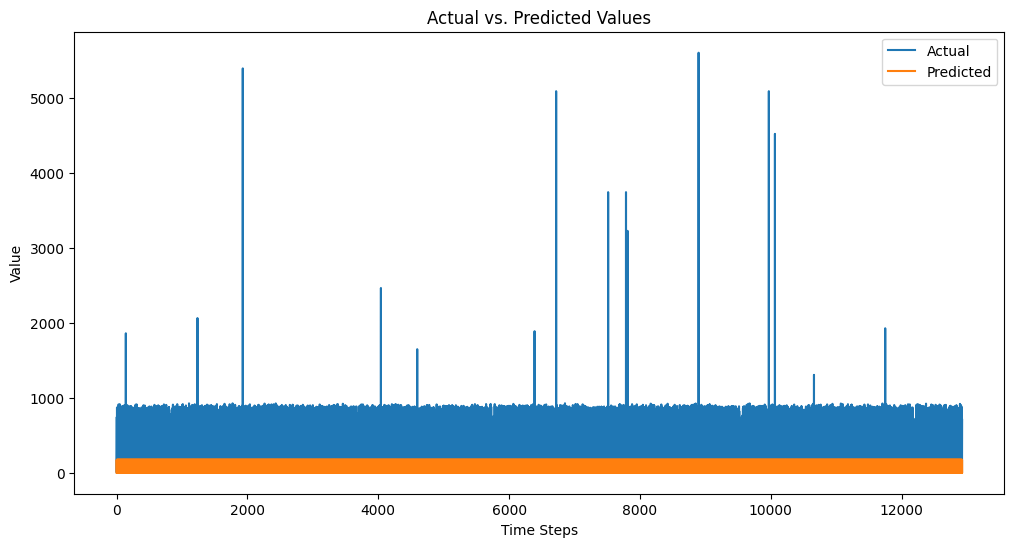

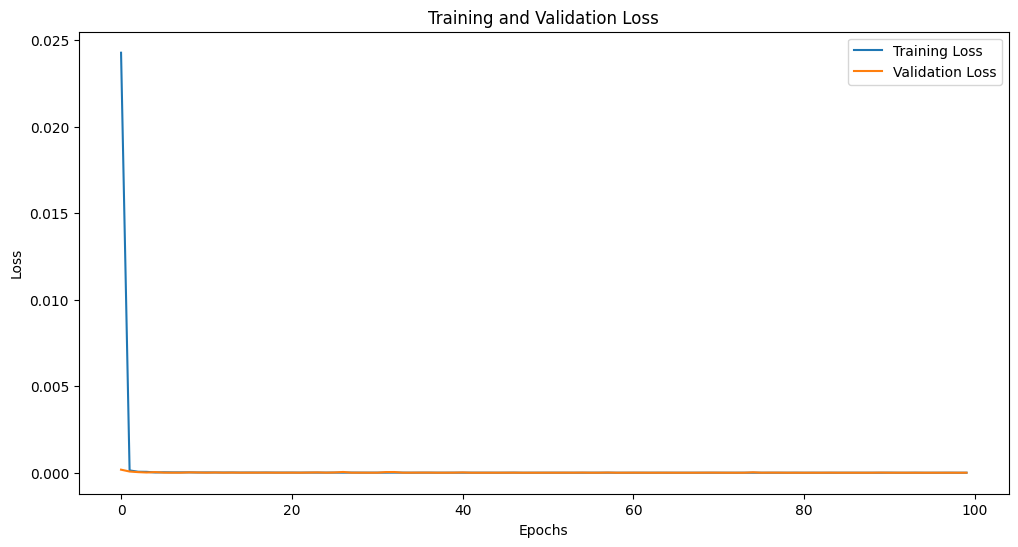

In [ ]:
# Training
# history = model.fit([X_train, y_train], y_train, epochs=10, batch_size=64, validation_data=([X_val, y_val], y_val))

# Evaluate the model on test data
test_loss = model.evaluate([X_test, np.zeros_like(y_test)], y_test)
print(f'Test Loss: {test_loss}')

# Make predictions using the trained model
predictions = model.predict([X_test, np.zeros_like(y_test)])

# Reshape predictions and actual values to 2D arrays
predictions_2d = predictions.reshape(predictions.shape[0], predictions.shape[1])
y_test_2d = y_test.reshape(y_test.shape[0], y_test.shape[1])

# Inverse transform the scaled predictions and actual values to the original scale
predictions_original = scaler.inverse_transform(predictions_2d)
y_test_original = scaler.inverse_transform(y_test_2d)

# Plotting the results
import matplotlib.pyplot as plt

# Plotting actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original.flatten(), label='Actual')
plt.plot(predictions_original.flatten(), label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
df=pd.read_csv("/content/Dataset.csv")
df.head()

,TIMESTAMP,A,B,C
0,2022032101,0,208,0
1,2022032103,0,225,0
2,2022032104,0,223,0
3,2022032104,0,221,0
4,2022032105,0,221,0


In [ ]:
# Convert Timestamp column to datetime type
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d%H')
df['TIMESTAMP'] = df['TIMESTAMP'].dt.date

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Load your time series data into a pandas DataFrame
# Assuming the DataFrame is named 'df'

# Sort the DataFrame by Timestamp if it's not already sorted
# df = df.sort_values(by='Timestamp')

# Define the number of time steps in the input sequence
input_window_size = 3  # You can adjust this based on your requirement

# Create input sequences and corresponding target sequences
input_sequences = []
target_sequences = []

for i in range(len(df) - input_window_size):
    input_seq = df[['A', 'B', 'C']][i:i+input_window_size].values
    target_seq = df[['A', 'B', 'C']][i+input_window_size:i+input_window_size+1].values
    input_sequences.append(input_seq)
    target_sequences.append(target_seq)

# Convert input_sequences and target_sequences to numpy arrays
input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)

# Divide the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(input_sequences, target_sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define model parameters
input_features = X_train.shape[2]  # Number of input features (3 in this case)
output_features = y_train.shape[2]  # Number of output features (also 3 in this case)
encoder_units = 64
decoder_units = 64
num_epochs = 50
batch_size = 64

# Define the encoder architecture
encoder_input = Input(shape=(None, input_features))
encoder_lstm, state_h, state_c = LSTM(encoder_units, return_state=True)(encoder_input)
encoder_states = [state_h, state_c]

# Define the decoder architecture with initial state set to encoder_states
decoder_input = Input(shape=(None, output_features))
decoder_lstm = LSTM(decoder_units, return_sequences=True, return_state=True)
decoder_lstm_outputs, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)
decoder_output = Dense(output_features)(decoder_lstm_outputs)

# Create the model
model = Model([encoder_input, decoder_input], decoder_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=num_epochs, batch_size=batch_size)

# Evaluate the model on the test data
loss = model.evaluate([X_test, y_test], y_test)
print(f'Test Loss: {loss}')

# Use the trained model for predictions
def forecast(input_sequence, prediction_horizon):
    initial_state = model.layers[1].get_initial_state(inputs=np.array([input_sequence]))
    encoder_states = model.layers[1](inputs=np.array([input_sequence]), initial_state=initial_state)

    decoder_input = np.zeros((1, 1, output_features))  # Initialize with zeros for single-step prediction
    forecasts = []

    for _ in range(prediction_horizon):
        decoder_output, _, _ = model.layers[2](inputs=decoder_input, initial_state=encoder_states)
        forecast_step = model.layers[3](decoder_output)
        forecasts.append(forecast_step)
        decoder_input = np.expand_dims(np.array([forecast_step]), axis=1)

    return np.concatenate(forecasts, axis=1)


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are your training, validation, and test data

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Encoder
encoder_inputs = Input(shape=input_shape)
encoder_lstm1 = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
encoder_lstm2 = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_lstm3 = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs2)

# State Vector
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, 1))  # Assuming univariate time series forecasting
decoder_lstm1 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_lstm2 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)
decoder_lstm3 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs3, _, _ = decoder_lstm3(decoder_outputs2)

# Fully Connected Layer
output = Dense(1)(decoder_outputs3)  # Output layer for univariate time series forecasting

# Model
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
model.fit([X_train, y_train], y_train, epochs=50, batch_size=64, validation_data=([X_val, y_val], y_val))

# Testing
predictions = model.predict([X_test, y_test])

# Evaluate the model as needed
